In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

##DeepONet Class

In [ ]:
class DeepONet(nn.Module):
    def __init__(self, n_sensor, p_dim=100, hidden_dim=256, T=1.0):
        """
        Args:
            n_sensor: Number of sensor points (input dimension for the branch net)
            p_dim: Dimension of the latent representations for branch and trunk nets.
            hidden_dim: Number of neurons in the hidden layers.
            T: Final time (used to enforce u(x, T)=0).
        """
        super(DeepONet, self).__init__()
        self.T = T  # Store the final time for enforcing boundary condition

        # Branch network: processes F_sensor (batch_size, n_sensor)
        self.branch_net = nn.Sequential(
            nn.Linear(n_sensor, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, p_dim)
        )

        # Trunk network: processes query points (n_query, 2)
        self.trunk_net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, p_dim)
        )

    def forward(self, F_sensor, query_points):
        """
        Args:
            F_sensor: Tensor of shape (batch_size, n_sensor)
            query_points: Tensor of shape (n_query, 2) where columns are (x, t)
        Returns:
            u_pred: Tensor of shape (batch_size, n_query)
                    with boundary conditions enforced.
        """
        # Compute latent representations
        branch_out = self.branch_net(F_sensor)      # (batch_size, p_dim)
        trunk_out = self.trunk_net(query_points)      # (n_query, p_dim)

        # Combine via inner product
        inner_prod = torch.matmul(branch_out, trunk_out.T)  # (batch_size, n_query)

        # Enforce boundary conditions:
        # u(0,t)=0  => multiplier vanishes at x=0
        # u(x,T)=0  => multiplier vanishes when t=T
        x = query_points[:, 0]         # (n_query,)
        t = query_points[:, 1]         # (n_query,)
        multiplier = x * (self.T - t)  # (n_query,)
        multiplier = multiplier.unsqueeze(0)  # reshape to (1, n_query) for broadcasting

        u_pred = inner_prod * multiplier  # (batch_size, n_query)
        return u_pred

## True_Solution_Version 2(Pytorch)

In [ ]:
def true_solution(input_tensor, gamma, rho, r, R, sigma,T):
    """
    input_tensor: (n_query, 2) — columns are (x, t)
    gamma: (batch_size, 1)
    returns u: (batch_size, n_query)
    """
    x = input_tensor[:, 0].unsqueeze(0)  # (1, n_query)
    t = input_tensor[:, 1].unsqueeze(0)  # (1, n_query)

    # Compute nu (batch_size, 1)
    nu = ((R - r)**2 / (2 * sigma**2 * (1 - gamma))) + r  # (batch_size, 1)

    # Broadcast (batch_size, n_query)
    exponent = -(rho - nu*gamma) * (T - t) / (1 - gamma)  # (batch_size, n_query)

    # Compute each term
    term1 = torch.exp(-rho * t)  # (1, n_query)
    term2 = ((1 - gamma) / (rho - nu*gamma))** (1 - gamma) # (batch_size, 1)
    term3 = (1 - torch.exp(exponent)) ** (1 - gamma)  # (batch_size, n_query)
    term4 = x ** gamma  # (batch_size, n_query)

    u = term1 * term2 * term3 * term4  # All broadcast to (batch_size, n_query)

    return u

##Generate Random function(a2) on [0,T] (GRF)

In [ ]:
def rbf_kernel(x1, x2, ell):
    """Squared exponential kernel."""
    return np.exp(-np.sum((x1 - x2) ** 2) / (2 * ell ** 2))

def covariance_matrix(x, ell):
    """Generate covariance matrix for inputs x with length scale ell."""
    N = len(x)
    K = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            K[i, j] = rbf_kernel(x[i], x[j], ell)
    return K

def sample_grf(x, ell, num_samples=1):
    """Sample from a Gaussian random field at locations x with length scale ell."""
    K = covariance_matrix(x, ell)
    mean = np.zeros(len(x))
    samples = np.random.multivariate_normal(mean, K, num_samples)
    return samples  # shape: (num_samples, len(x))

##Generate Data

In [ ]:
def generate_data_with_grf(batch_size, n_sensor, n_query, T, X, rho, r, R, sigma, ell):
    # Step 1: Sample gamma values in (0,1)
    gamma = torch.full((batch_size, 1), 0.5)

    # Step 2: Create shared sensor time grid
    t_sensor_np = np.linspace(0, T, n_sensor)  # (n_sensor,)
    t_sensor = torch.tensor(t_sensor_np, dtype=torch.float32).unsqueeze(0).repeat(batch_size, 1)  # (B, n_sensor)

    # Step 3: Generate random functions a2(t) using GRF
    grf_samples = sample_grf(t_sensor_np, ell=ell, num_samples=batch_size)  # (B, n_sensor)
    a2 = torch.tensor(grf_samples, dtype=torch.float32)

    # Step 4: Define F = |a2|^gamma element-wise
    F_sensor = torch.pow(torch.abs(a2), gamma)  # (B, n_sensor)

    # Step 5: Sample query points (shared across batch)
    t_query = T * torch.rand(n_query, 1)
    x_query = X * torch.rand(n_query, 1)
    query_points = torch.cat([x_query, t_query], dim=1)  # (n_query, 2)

    # Step 6: Compute true solution per batch
    u_true = true_solution(query_points, gamma, rho, r, R, sigma, T)




    return F_sensor, query_points, u_true


##Training Function

In [ ]:
def train_DeepOnet(batch_size, n_sensor, n_query, T, X, rho, r, R, sigma, ell, learning_rate, n_epochs):
    """
    Train the DeepONet model.

    Args:
        batch_size: Number of samples per batch.
        n_sensor: Number of sensor points.
        n_query: Number of query points.
        T: Final time.
        X: Spatial domain limit.
        rho, r, R, sigma: Parameters for the PDE true solution.
        ell: Length scale for the GRF.
        learning_rate: Learning rate for the Adam optimizer.
        n_epochs: Number of epochs to train.

    Returns:
        model: The trained DeepONet model.
    """
    # Initialize the model; pass T so that the multiplier in forward enforces u(x,T)=0.
    model = DeepONet(n_sensor=n_sensor, p_dim=100, hidden_dim=256, T=T)

    # Use Adam optimizer with the specified learning rate.
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    mse_loss = nn.MSELoss()  # This returns a scalar loss.
    loss_history = []  # ← Store loss values

    for epoch in range(n_epochs):
        model.train()

        # Generate training data
        F_sensor, query_points, u_true = generate_data_with_grf(
            batch_size, n_sensor, n_query, T, X, rho, r, R, sigma, ell
        )

        # Forward pass: predict u for the given F_sensor and query points.
        u_pred = model(F_sensor, query_points)  # Expected shape: (batch_size, n_query)

        # Compute the MSE loss (averaged over all elements to yield a scalar).
        loss = mse_loss(u_pred, u_true)

        # Backpropagation and optimization step
        optimizer.zero_grad()  # Reset gradients
        loss.backward()        # Backpropagate the loss
        optimizer.step()       # Update the model parameters


        loss_value = loss.item()
        loss_history.append(loss_value)

        # Print loss every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.6f}")



    plt.figure(figsize=(8, 4))
    plt.plot(loss_history, label='Training Loss')
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("DeepONet Training Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return model

In [ ]:
train_DeepOnet(64, 100, 100, 1, 1, 0.2, 0.01, 0.05, 0.4, 0.8, 0.00001, 10000)

Epoch 100/10000, Loss: 0.067055
Epoch 200/10000, Loss: 0.028833
Epoch 300/10000, Loss: 0.022533
Epoch 400/10000, Loss: 0.013166
Epoch 500/10000, Loss: 0.008901
Epoch 600/10000, Loss: 0.005352
Epoch 700/10000, Loss: 0.004624
Epoch 800/10000, Loss: 0.003596
Epoch 900/10000, Loss: 0.002871
Epoch 1000/10000, Loss: 0.002290
Epoch 1100/10000, Loss: 0.001805
Epoch 1200/10000, Loss: 0.001789
Epoch 1300/10000, Loss: 0.001610
Epoch 1400/10000, Loss: 0.001549
Epoch 1500/10000, Loss: 0.001538
Epoch 1600/10000, Loss: 0.001132
Epoch 1700/10000, Loss: 0.001047
Epoch 1800/10000, Loss: 0.001123
Epoch 1900/10000, Loss: 0.000923
Epoch 2000/10000, Loss: 0.000831
Epoch 2100/10000, Loss: 0.000892
Epoch 2200/10000, Loss: 0.000683
Epoch 2300/10000, Loss: 0.000458
Epoch 2400/10000, Loss: 0.000781
Epoch 2500/10000, Loss: 0.000420
Epoch 2600/10000, Loss: 0.000471
Epoch 2700/10000, Loss: 0.000517
Epoch 2800/10000, Loss: 0.000495
Epoch 2900/10000, Loss: 0.000417
Epoch 3000/10000, Loss: 0.000405
Epoch 3100/10000, L

DeepONet(
  (branch_net): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=100, bias=True)
  )
  (trunk_net): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=100, bias=True)
  )
)

##3d Plot

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting

def plot_true_vs_learned_3d(model, n_sensor, n_query_per_axis, T, X, rho, r, R, sigma, ell):
    model.eval()

    batch_size = 1
    gamma = torch.full((batch_size, 1), 0.5)

    # Create a grid of query points over [0, X] × [0, T]
    x_vals = np.linspace(0, X, n_query_per_axis)
    t_vals = np.linspace(0, T, n_query_per_axis)
    x_grid, t_grid = np.meshgrid(x_vals, t_vals)
    x_flat = x_grid.flatten()
    t_flat = t_grid.flatten()
    query_points = torch.tensor(np.stack([x_flat, t_flat], axis=1), dtype=torch.float32)

    # Generate a fixed F_sensor using GRF
    t_sensor_np = np.linspace(0, T, n_sensor)
    grf_samples = sample_grf(t_sensor_np, ell=ell, num_samples=1)
    a2 = torch.tensor(grf_samples, dtype=torch.float32)
    F_sensor = torch.pow(torch.abs(a2), gamma)

    # Compute true and predicted solution
    with torch.no_grad():
        u_true = true_solution(query_points, gamma, rho, r, R, sigma, T).squeeze(0).numpy()
        u_pred = model(F_sensor, query_points).squeeze(0).numpy()

    # Reshape to grid shape for surface plotting
    u_true_grid = u_true.reshape(n_query_per_axis, n_query_per_axis)
    u_pred_grid = u_pred.reshape(n_query_per_axis, n_query_per_axis)

    # Plot 3D surfaces
    fig = plt.figure(figsize=(14, 6))

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.plot_surface(x_grid, t_grid, u_true_grid, cmap='viridis')
    ax1.set_title('True Solution')
    ax1.set_xlabel('x')
    ax1.set_ylabel('t')
    ax1.set_zlabel('u(x,t)')

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.plot_surface(x_grid, t_grid, u_pred_grid, cmap='viridis')
    ax2.set_title('DeepONet Prediction')
    ax2.set_xlabel('x')
    ax2.set_ylabel('t')
    ax2.set_zlabel('u(x,t)')

    plt.tight_layout()
    plt.show()

Epoch 100/10000, Loss: 0.038497
Epoch 200/10000, Loss: 0.032025
Epoch 300/10000, Loss: 0.025927
Epoch 400/10000, Loss: 0.017088
Epoch 500/10000, Loss: 0.011725
Epoch 600/10000, Loss: 0.009555
Epoch 700/10000, Loss: 0.006188
Epoch 800/10000, Loss: 0.004107
Epoch 900/10000, Loss: 0.002837
Epoch 1000/10000, Loss: 0.003152
Epoch 1100/10000, Loss: 0.002563
Epoch 1200/10000, Loss: 0.002356
Epoch 1300/10000, Loss: 0.002284
Epoch 1400/10000, Loss: 0.002207
Epoch 1500/10000, Loss: 0.001740
Epoch 1600/10000, Loss: 0.001464
Epoch 1700/10000, Loss: 0.001536
Epoch 1800/10000, Loss: 0.001479
Epoch 1900/10000, Loss: 0.001150
Epoch 2000/10000, Loss: 0.001174
Epoch 2100/10000, Loss: 0.001030
Epoch 2200/10000, Loss: 0.000931
Epoch 2300/10000, Loss: 0.001072
Epoch 2400/10000, Loss: 0.000801
Epoch 2500/10000, Loss: 0.000889
Epoch 2600/10000, Loss: 0.000680
Epoch 2700/10000, Loss: 0.000620
Epoch 2800/10000, Loss: 0.000497
Epoch 2900/10000, Loss: 0.000529
Epoch 3000/10000, Loss: 0.000525
Epoch 3100/10000, L

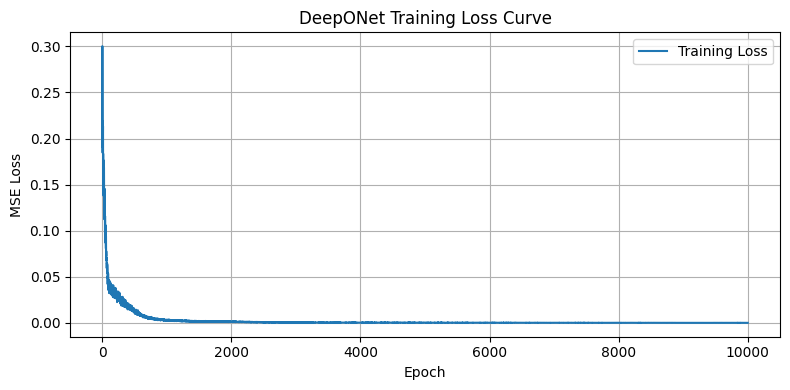

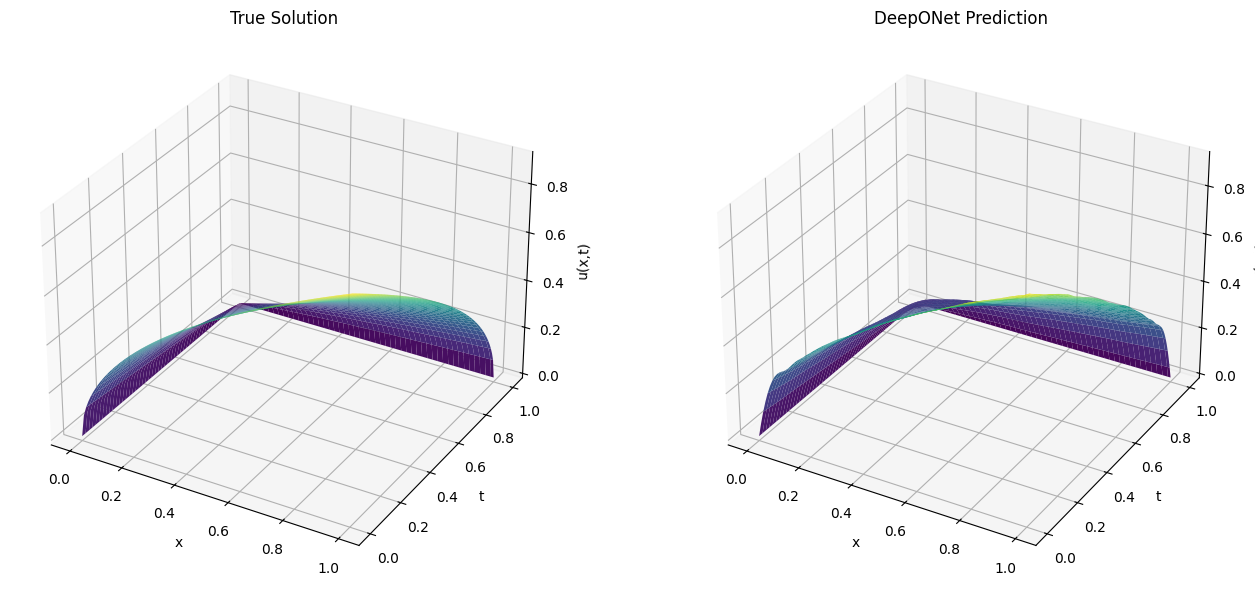

In [ ]:
model=train_DeepOnet(64, 100, 100, 1, 1, 0.2, 0.01, 0.05, 0.4, 0.8, 0.00001, 10000)
plot_true_vs_learned_3d(model, 100, 100, 1, 1, 0.2, 0.01, 0.05, 0.4, 0.8)